In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [4]:
### try autoregressive RNN model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# model.to(device)

cuda:0


In [6]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [7]:
df = pd.read_csv('../../eICU/training/finalData.csv')
df

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
0,143870,7.0,37.132325,44.0,86.0,111.000000,0.89,11.7,2.30671,3.870968,0.0
1,143870,10.0,37.132325,43.0,80.5,112.500000,0.89,11.7,2.30671,3.870968,0.0
2,143870,12.0,37.132325,42.0,75.0,114.000000,0.89,11.7,2.30671,3.870968,0.0
3,143870,17.0,37.132325,41.0,78.0,113.000000,0.89,11.7,2.30671,3.870968,0.0
4,143870,22.0,37.132325,41.0,73.0,113.000000,0.89,11.7,2.30671,3.870968,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1230089,3353113,2671.0,37.132325,87.0,27.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230090,3353113,2676.0,37.132325,85.0,27.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230091,3353113,2681.0,37.132325,84.0,26.0,125.654566,0.57,5.0,1.80000,0.852273,0.0
1230092,3353113,2686.0,37.132325,84.0,25.0,125.654566,0.57,5.0,1.80000,0.852273,0.0


In [8]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['temperature', 'heartrate', 'respiration', 'systemicsystolic', 'creatinine', 'wbcx1000', 'lactate', 'urineoutputbyweight']].values
targets = df['diagnosis'].values

In [9]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)
D

8

In [10]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [11]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [12]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [13]:
# make the RNN
model = RNN(8, 5, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(8, 5, num_layers=2, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [16]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [30]:
torch.cuda.empty_cache()

In [20]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=1000)

Epoch 5/1000, Train Loss: 0.0159, Test Loss: 0.0161
Epoch 10/1000, Train Loss: 0.0150, Test Loss: 0.0153
Epoch 15/1000, Train Loss: 0.0142, Test Loss: 0.0145
Epoch 20/1000, Train Loss: 0.0135, Test Loss: 0.0138
Epoch 25/1000, Train Loss: 0.0128, Test Loss: 0.0132
Epoch 30/1000, Train Loss: 0.0122, Test Loss: 0.0126
Epoch 35/1000, Train Loss: 0.0117, Test Loss: 0.0121
Epoch 40/1000, Train Loss: 0.0112, Test Loss: 0.0116
Epoch 45/1000, Train Loss: 0.0107, Test Loss: 0.0111
Epoch 50/1000, Train Loss: 0.0103, Test Loss: 0.0107
Epoch 55/1000, Train Loss: 0.0099, Test Loss: 0.0103
Epoch 60/1000, Train Loss: 0.0095, Test Loss: 0.0100
Epoch 65/1000, Train Loss: 0.0092, Test Loss: 0.0096
Epoch 70/1000, Train Loss: 0.0088, Test Loss: 0.0093
Epoch 75/1000, Train Loss: 0.0085, Test Loss: 0.0090
Epoch 80/1000, Train Loss: 0.0082, Test Loss: 0.0087
Epoch 85/1000, Train Loss: 0.0080, Test Loss: 0.0085
Epoch 90/1000, Train Loss: 0.0077, Test Loss: 0.0083
Epoch 95/1000, Train Loss: 0.0075, Test Loss: 0

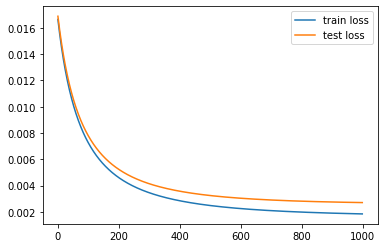

In [21]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [22]:
# Get accuracy
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9998, Test acc: 0.9997
